## Compound annotation evaluation

### Import package and load data

In [1]:
import pandas as pd

compounds = pd.read_csv('data/compound_list.csv', encoding = 'gbk')

### Result of various tools

In [2]:
# AutoMS
from AutoMS.automs import AutoMS

file = 'data/600mix_pos.mzML'
peaks = AutoMS(file, min_intensity = 500)
peaks = peaks.sort_values('score', ascending=False, ignore_index=True)

# XCMS
xcms = pd.read_csv('data/XCMS_output.csv')
xcms = xcms.sort_values('sn', ascending=False, ignore_index=True)

# MS-DIAL
ms_dial = pd.read_csv('data/MS_DIAL_output.csv')
ms_dial = ms_dial.sort_values('S/N', ascending=False, ignore_index=True)

# Peakonly
peakonly = pd.read_csv('data/peakonly_output.csv')

D:\AutoMS\AutoMS\mspd.py:100: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  col = int(mode(ridge[1, inds])[0][0])
100%|█████████████████████████████████████████████████████████████████████████| 25257/25257 [00:01<00:00, 17428.51it/s]


790/790 [==============================] - 3s 1ms/step


### Count M+H features of standards

In [3]:
import numpy as np
from tqdm import tqdm

def count_true_positive(data, colname = 'Precursor m/z'):
    identified = []
    count = 0
    for i in compounds.index:
        pred_precursor = compounds.loc[i, 'ExactMass'] + 1.0078
        if np.min(np.abs(data[colname] - pred_precursor)) <= 0.1:
            identified.append(compounds.loc[i, 'Name'])
            count += 1
        else:
            pass
    return count, identified


x = np.arange(1, 7100, 300)
y_automs, y_xcms, y_msdial = [], [], []
for n in tqdm(x):
    y_automs_, _ = count_true_positive(peaks.loc[:n,:], 'mz')
    y_xcms_, _ = count_true_positive(xcms.loc[:n,:], 'mz')
    y_msdial_, _ = count_true_positive(ms_dial.loc[:n,:], 'Precursor m/z')
    y_automs.append(y_automs_)
    y_xcms.append(y_xcms_)
    y_msdial.append(y_msdial_)
y_peakonly, _ = count_true_positive(peakonly, 'mz')

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.63it/s]


### Plot curves

Text(0, 0.5, 'Features of M+H of standards')

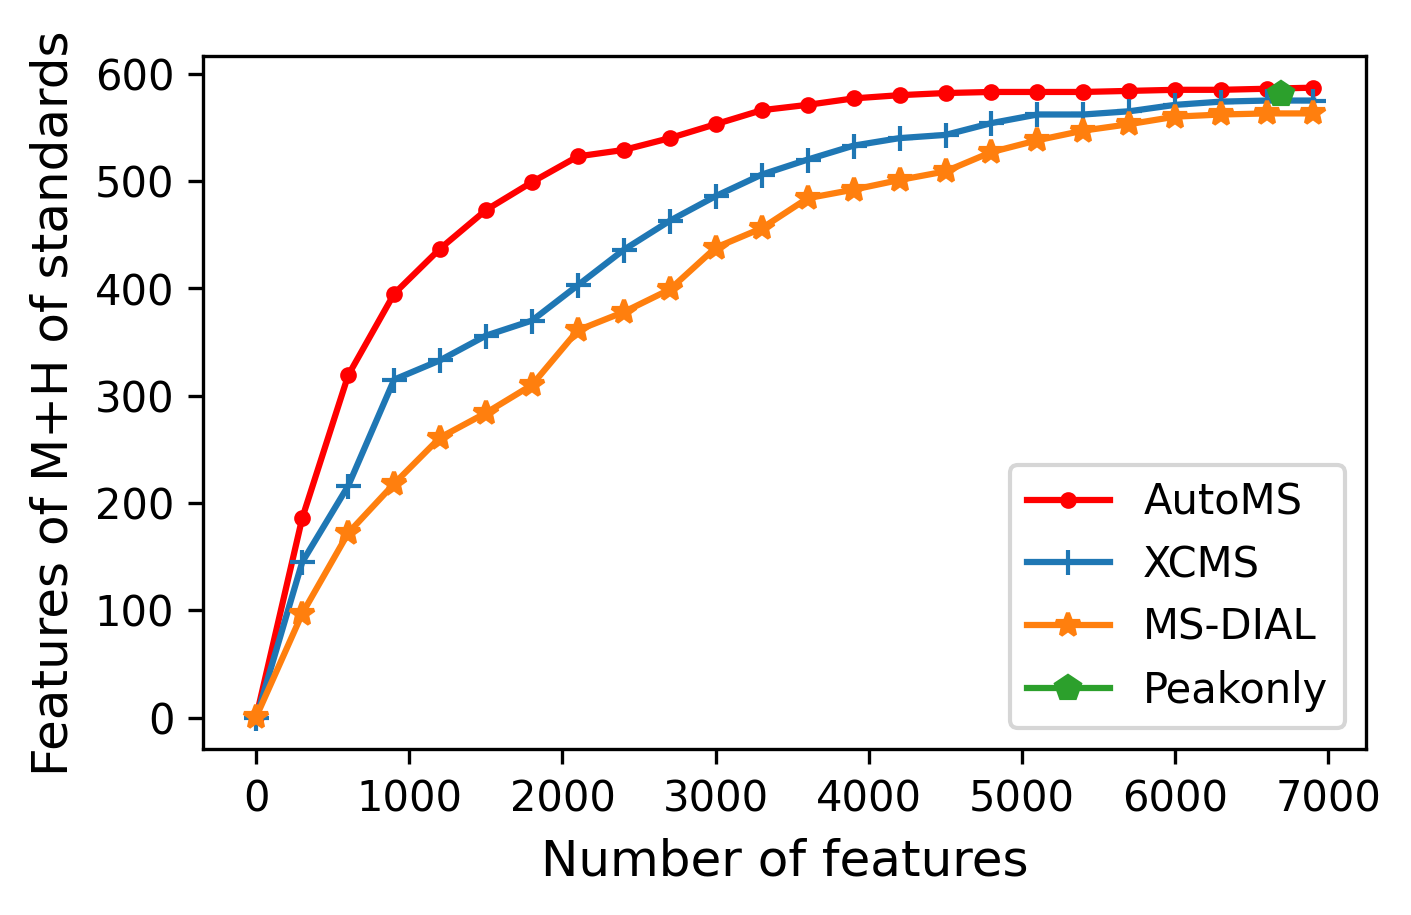

In [4]:
import matplotlib.pyplot as plt
plt.figure(dpi = 300, figsize=(5, 3))
plt.plot(x, y_automs, marker='.', color='r', label='AutoMS')
plt.plot(x, y_xcms, marker='+', label='XCMS')
plt.plot(x, y_msdial, marker='*', label='MS-DIAL')
plt.plot(len(peakonly), y_peakonly, marker='p', label='Peakonly')
plt.legend()
plt.xlabel('Number of features', fontsize=12)
plt.ylabel('Features of M+H of standards', fontsize=12)

### Plot Venn

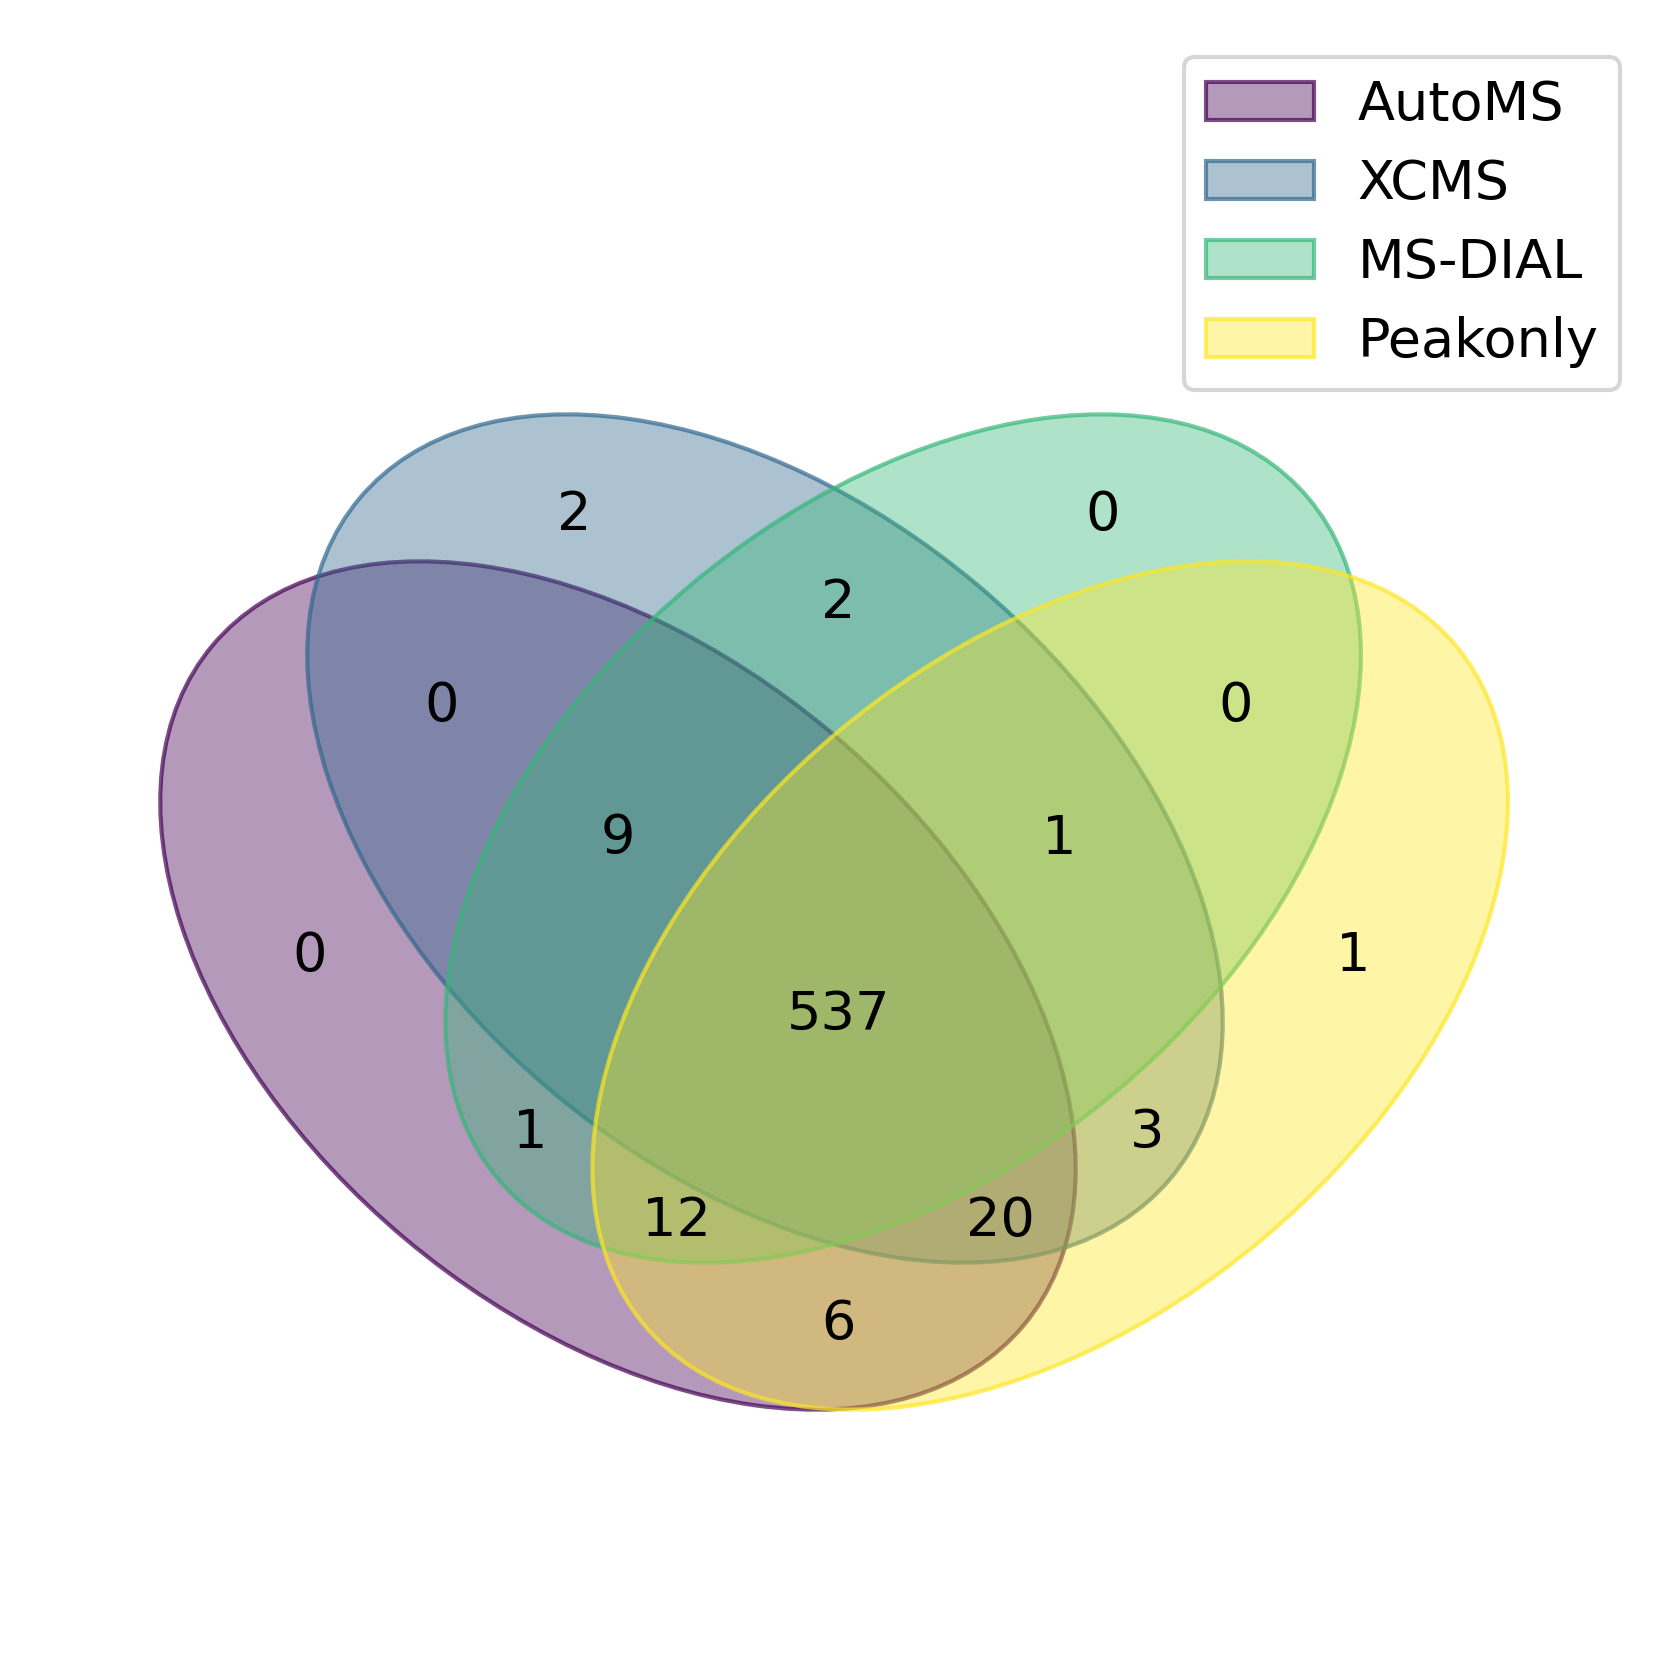

In [5]:
from venn import venn
# Need: pip install venn

n = min(len(peaks), len(xcms), len(ms_dial), len(peakonly))
y_automs_, id_automs = count_true_positive(peaks.loc[:n,:], 'mz')
y_xcms_, id_xcms = count_true_positive(xcms.loc[:n,:], 'mz')
y_msdial_, id_msdial = count_true_positive(ms_dial.loc[:n,:], 'Precursor m/z')
y_peakonly, id_peakonly = count_true_positive(peakonly.loc[:n,:], 'mz')

venn_data = {
    "AutoMS": set(id_automs),
    "XCMS": set(id_xcms),
    "MS-DIAL": set(id_msdial),
    "Peakonly": set(id_peakonly)
}

figure, ax = plt.subplots(dpi = 300, figsize=(8, 7))
venn(venn_data, ax=ax)
plt.show()